In [1]:
import pandas as pd
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns


import sys
sys.path.append("../")
import xfinai_config
from utils import base_io, plotter

plt.rcParams['font.sans-serif'] = 'SimHei'

## 0 Load Attention Weights

In [2]:
future_index = 'IC'
params = base_io.load_best_params(future_index, 'EncoderGRU_AttnDecoderGRU')
train_data, val_data, test_data = base_io.load_data(future_index)
attention_weights_path = "./attention_weights/IC/EncoderGRU_AttnDecoderGRU/attention_weights.pkl"
attention_weights_map = joblib.load(attention_weights_path)

In [3]:
attention_weights_train = attention_weights_map['训练集']
attention_weights_val = attention_weights_map['验证集']
attention_weights_test = attention_weights_map['测试集']

## 1 Convert to DF

In [4]:
def convert2df(weights_map):
    weights_df = pd.DataFrame()
    for weight in weights_map:
        weight_df = pd.DataFrame(weight)
        weights_df = pd.concat([weights_df, weight_df])
        weights_df.reset_index(inplace=True, drop=True)
    return weights_df

In [5]:
train_attn_weights_df = convert2df(attention_weights_train)
val_attn_weights_df = convert2df(attention_weights_val)
test_attn_weights_df = convert2df(attention_weights_test)
train_attn_weights_df.index = train_data.index[:train_attn_weights_df.shape[0]]
val_attn_weights_df.index = val_data.index[:val_attn_weights_df.shape[0]]
test_attn_weights_df.index = test_data.index[:test_attn_weights_df.shape[0]]

## 2 Plot Attention weights per time Bar

In [6]:
train_attn_weights_mean = train_attn_weights_df.mean()
val_attn_weights_mean = val_attn_weights_df.mean()
test_attn_weights_mean = test_attn_weights_df.mean()

In [7]:
bar_plot_df = pd.DataFrame([train_attn_weights_mean, val_attn_weights_mean, test_attn_weights_mean], index=['训练集', '验证集', '测试集'])
bar_plot_df.columns=[f"t-{params['seq_length'] - i}"  for i in range(params['seq_length'])]
bar_plot_df.index.name='数据集'
bar_plot_df.columns.name='时间点'

plot_df = bar_plot_df.stack().reset_index()
plot_df = plot_df.rename(columns={0:'注意力权重'})

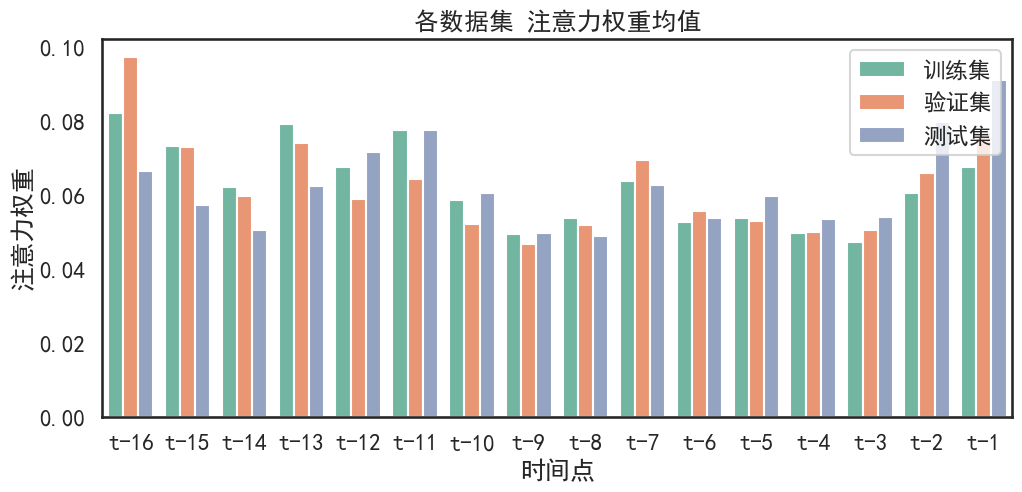

In [17]:
plt.figure(figsize=[14, 6], dpi=100)
sns.set_theme(style="white", context="talk", palette='Set2', rc=plotter.rc_params)
plt.title(f"各数据集 注意力权重均值")
sns.barplot(data=plot_df, x='时间点', y='注意力权重', hue='数据集')
plt.legend(loc='upper right')
plt.subplots_adjust(bottom=0.25, left=0.25)

## 3 Plot Attention weights change through time

In [13]:
def plot_series_apply_func(series):
    plt.plot(series.values, label = f"t-{(params['seq_length']-int(series.name))}")

In [14]:
show_attn_weights_df = test_attn_weights_df.copy(deep=True)[-240:]

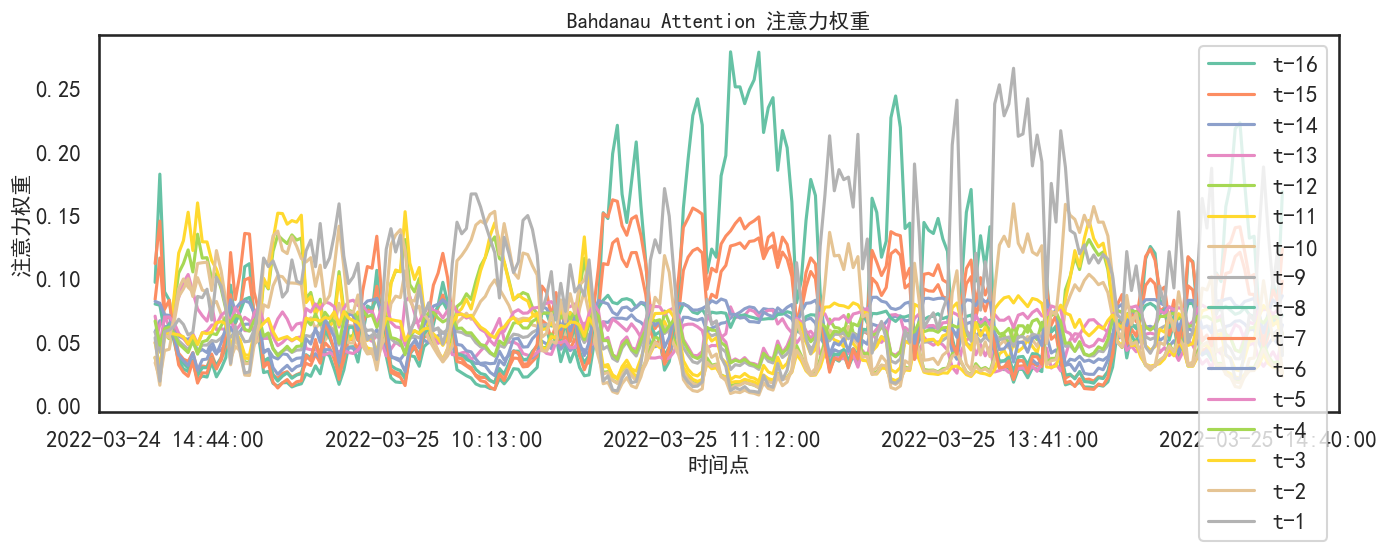

In [15]:
plt.figure(figsize=[16,5], dpi=100)
plt.title("Bahdanau Attention 注意力权重", size=15)
show_attn_weights_df.apply(plot_series_apply_func, axis=0)

x_ticks = range(0, len(show_attn_weights_df.index), 59)
plt.xticks(ticks=x_ticks, labels=[show_attn_weights_df.index[i] for i in x_ticks])

plt.xlabel('时间点', size=15)
plt.ylabel('注意力权重', size=15)
plt.legend()
plt.show()